  
# Доменная область: «Телеком»

**План:**  
- Проработка запроса
- Описание и постановка цели проекта
- Загрузка данных
- Ознакомление с данными
- Обработака данных(заполнение пропусков, изменение типов данных и тд)
- Объединение таблиц
- Удаление лишних столбцов, которые не влияют на результат, либо имеют мультиколлинеарность с целевым признаком
- Обработка данных перед обучением модели
- Разделение на выборки
- Обучение нескольких моделей с подбором гиперпараметров
- Выявление лучшей модели и проведение итогового тестирования
- Написание выводов
- Написание отчета



**Описание данных**   
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.   
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.   
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.   
Решается задача классификации.
   
Оператор предоставляет два основных типа услуг:   
-Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.   
-Интернет.   

Подключение может быть двух типов:    
-через телефонную линию (DSL)    
-оптоволоконный кабель (Fiber optic).   

Также доступны такие услуги:   
-Интернет-безопасность: антивирус (DeviceProtection)   
-блокировка небезопасных сайтов (OnlineSecurity);   
-Выделенная линия технической поддержки (TechSupport);   
-Облачное хранилище файлов для резервного копирования данных (OnlineBackup);   
-Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).   

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года.   
Доступны различные способы расчёта и возможность получения электронного чека.

Данные состоят из файлов, полученных из разных источников:   
	contract_new.csv — информация о договоре;   
	personal_new.csv — персональные данные клиента;   
	internet_new.csv — информация об интернет-услугах;   
	phone_new.csv — информация об услугах телефонии.   

Во всех файлах столбец customerID содержит код клиента.   

Информация о договорах актуальна на 1 февраля 2020.   


Описание столбцов:   
BeginDate – дата начала пользования услугами,   
EndDate – дата окончания пользования услугами,   
Type – тип оплаты: ежемесячный, годовой и тд,   
PaperlessBilling – электронный платёжный документ,   
PaymentMethod – способ оплаты,   
MonthlyCharges – ежемесячные траты на услуги,   
TotalCharges – всего потрачено денег на услуги   
Dependents – наличие иждивенцев   
Senior Citizen – наличие пенсионного статуса по возрасту   
Partner – наличие супруга(и)   
MultipleLines – наличие возможности ведения параллельных линий во время звонка   

**Цель:**  
Подобрать модель для прогнозирования оттока клиентов, минимальный порог для успешной сдачи : AUC-ROC>=0.85.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, cv

from sklearn.preprocessing import  OneHotEncoder


import re
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier

import datetime

RANDOM_STATE = 140823


In [2]:
%%capture
# install phik (if not installed yet)
import sys

!"{sys.executable}" -m pip install phik

import phik


# Загрузка и обзор данных

In [3]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')


In [4]:
display(contract.head())
display(personal.head())
display(internet.head())
display(phone.head())
print(contract.info(),personal.info(),internet.info(), phone.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   D

Так как данных у нас не много и ресурсов они расходуют немного для удабства дальнейшей обработки таблицы можно сразу объединить.

In [5]:
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Проверим результат, должно получиться 20 колонок и 7043 строки.

In [6]:

df.shape


(7043, 20)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Приведем названия колонок к нижнему регистру

In [8]:

df.columns=[re.sub(r'(?<!^)(?=[A-Z])','_',i).lower()for i in df.columns]
df.columns

Index(['customer_i_d', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines'],
      dtype='object')

Проверив значения в total_charges мы обнаружили 11 пустых значений, тк их очень мало и они не повлияют на обучение их можно удалить.

In [9]:
df['total_charges'].value_counts()

           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
2772.45     1
193.2       1
1436.19     1
1359.38     1
975.0       1
Name: total_charges, Length: 6658, dtype: int64

In [10]:
df = df.loc[df['total_charges'] != ' ']
df['total_charges'].value_counts()

20.45      6
101.0      5
21.53      4
732.6      4
1007.5     4
          ..
2772.45    1
193.2      1
1436.19    1
1359.38    1
975.0      1
Name: total_charges, Length: 6657, dtype: int64

Изменим тип данных

In [11]:

df['monthly_charges'] = df['monthly_charges'].astype(int)
df['total_charges'] = pd.to_numeric(df['total_charges'])
df['total_charges'] = df['total_charges'].astype(int)


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_i_d       7032 non-null   object
 1   begin_date         7032 non-null   object
 2   end_date           7032 non-null   object
 3   type               7032 non-null   object
 4   paperless_billing  7032 non-null   object
 5   payment_method     7032 non-null   object
 6   monthly_charges    7032 non-null   int64 
 7   total_charges      7032 non-null   int64 
 8   gender             7032 non-null   object
 9   senior_citizen     7032 non-null   int64 
 10  partner            7032 non-null   object
 11  dependents         7032 non-null   object
 12  internet_service   5512 non-null   object
 13  online_security    5512 non-null   object
 14  online_backup      5512 non-null   object
 15  device_protection  5512 non-null   object
 16  tech_support       5512 non-null   object


Добавим целевой признак, 1 - если клиент ушел, 0 - если клиент остался.

In [12]:

df['target'] = [1 if i != 'No' else 0 for i in df['end_date']]
df.head(10)

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29,31,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56,2071,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53,226,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42,1960,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70,353,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99,1150,Female,0,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89,2058,Male,0,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29,300,Female,0,...,No,DSL,Yes,No,No,No,No,No,NaN,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104,3573,Female,0,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56,1628,Male,0,...,Yes,DSL,Yes,Yes,No,No,No,No,No,1


Посмотрим уникальные значения в колонке end_date

In [13]:
df['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Если нет даты, значит клиент действующий, тк наши данные актуальны на 1 февраля 2020 года,этой датой и заполним значения "no".

In [14]:

df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01'
df['end_date'].unique()


array(['2020-02-01', '2017-05-01', '2016-03-01', '2018-09-01',
       '2018-11-01', '2018-12-01', '2019-08-01', '2018-07-01',
       '2017-09-01', '2015-09-01', '2016-07-01', '2016-06-01',
       '2018-03-01', '2019-02-01', '2018-06-01', '2019-06-01',
       '2020-01-01', '2019-11-01', '2016-09-01', '2015-06-01',
       '2016-12-01', '2019-05-01', '2019-04-01', '2017-06-01',
       '2017-08-01', '2018-04-01', '2018-08-01', '2018-02-01',
       '2019-07-01', '2015-12-01', '2014-06-01', '2018-10-01',
       '2019-01-01', '2017-07-01', '2017-12-01', '2018-05-01',
       '2015-11-01', '2019-10-01', '2019-03-01', '2016-02-01',
       '2016-10-01', '2018-01-01', '2017-11-01', '2015-10-01',
       '2019-12-01', '2015-07-01', '2017-04-01', '2015-02-01',
       '2017-03-01', '2016-05-01', '2016-11-01', '2015-08-01',
       '2019-09-01', '2017-10-01', '2017-02-01', '2016-08-01',
       '2016-04-01', '2015-05-01', '2014-09-01', '2014-10-01',
       '2017-01-01', '2015-03-01', '2015-01-01', '2016-

Теперь мы можем создать доп признак, сколько дней абонент является клиентом компании.

In [15]:

df['end_date'] = pd.to_datetime(df['end_date'])
df['begin_date'] = pd.to_datetime(df['begin_date'])

df['days'] = (df['end_date'] - df['begin_date']).dt.days

In [16]:
df.head()

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,target,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29,31,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56,2071,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53,226,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42,1960,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70,353,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


In [17]:
#Теперь можно удалить лишние столбцы id клиента, дату начала иконца, 
df = df.drop(columns=['customer_i_d', 'begin_date', 'end_date'])

In [18]:
df.head(10)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,target,days
0,Month-to-month,Yes,Electronic check,29,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0,31
1,One year,No,Mailed check,56,2071,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53,226,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42,1960,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
4,Month-to-month,Yes,Electronic check,70,353,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153
5,Month-to-month,Yes,Electronic check,99,1150,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0,337
6,Month-to-month,Yes,Credit card (automatic),89,2058,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0,671
7,Month-to-month,No,Mailed check,29,300,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN,0,306
8,Month-to-month,Yes,Electronic check,104,3573,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0,945
9,One year,No,Bank transfer (automatic),56,1628,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No,1,882


In [19]:
#Посмотрим пропуски
df.isnull().sum()

type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_t_v        1520
streaming_movies     1520
multiple_lines        680
target                  0
days                    0
dtype: int64

Пропуски есть, предположим, что если отсутствует значение, значит клиент данной услугой не пользуется и заполним пропуски значением 'no'

In [20]:
df.fillna('No_servis', inplace=True)
df.isnull().sum()

type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
multiple_lines       0
target               0
days                 0
dtype: int64

проверим и удалим дубликаты, если они есть

In [21]:
df['senior_citizen'] = df['senior_citizen'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type               7032 non-null   object
 1   paperless_billing  7032 non-null   object
 2   payment_method     7032 non-null   object
 3   monthly_charges    7032 non-null   int64 
 4   total_charges      7032 non-null   int64 
 5   gender             7032 non-null   object
 6   senior_citizen     7032 non-null   object
 7   partner            7032 non-null   object
 8   dependents         7032 non-null   object
 9   internet_service   7032 non-null   object
 10  online_security    7032 non-null   object
 11  online_backup      7032 non-null   object
 12  device_protection  7032 non-null   object
 13  tech_support       7032 non-null   object
 14  streaming_t_v      7032 non-null   object
 15  streaming_movies   7032 non-null   object
 16  multiple_lines     7032 non-null   object


In [22]:

print('Количество строк дубликатов: ',df.duplicated().sum())

Количество строк дубликатов:  73


In [23]:
df = df.drop_duplicates().reset_index(drop=True)
print('Количество строк дубликатов: ',df.duplicated().sum())


Количество строк дубликатов:  0


In [24]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,target,days
0,Month-to-month,Yes,Electronic check,29,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No_servis,0,31
1,One year,No,Mailed check,56,2071,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53,226,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42,1960,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No_servis,0,1371
4,Month-to-month,Yes,Electronic check,70,353,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


Оценим корреляцию численных и категорийных признаков.

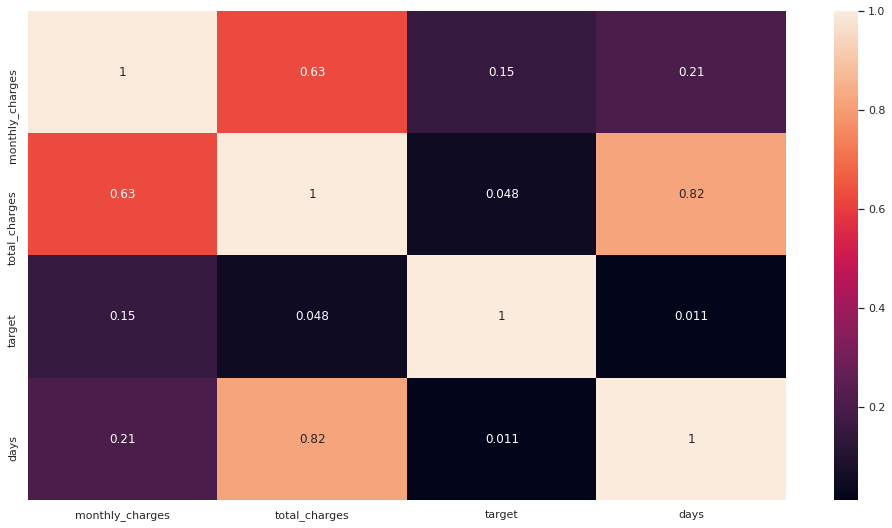

In [25]:

import seaborn as sns 
pearson=df.corr()
sns.set(rc = {'figure.figsize':(17,9)})
sns.heatmap(data=pearson,annot=True,);

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'target', 'days']


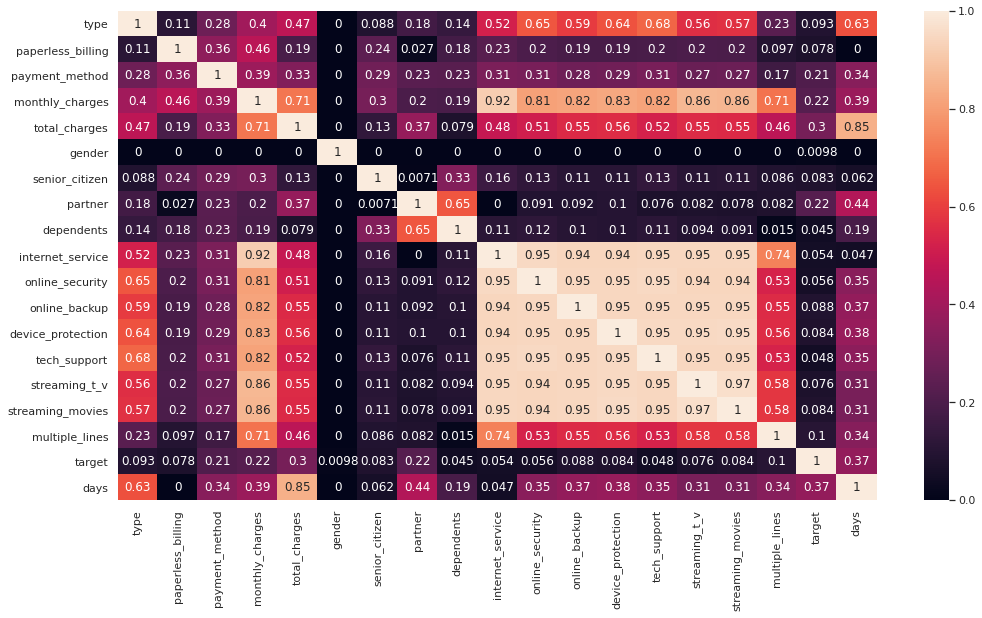

In [26]:

import seaborn as sns 
corr=df.phik_matrix()
sns.set(rc = {'figure.figsize':(17,9)})
sns.heatmap(data=corr,annot=True,);

Видим очень большую корреляцию у некоторых признаков другими, попробуем их удалить, что бы не перегружать модель.   
   
Удаление избыточных признаков позволяет лучше понять данные, а также сократить время настройки модели, улучшить её точность и облегчить интерпретируемость.

In [27]:
df = df.drop(columns=['internet_service', 'online_security', 'online_backup',
                      'streaming_movies', 'device_protection', 'tech_support'], axis=1) 

In [28]:
df.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents',
       'streaming_t_v', 'multiple_lines', 'target', 'days'],
      dtype='object')

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'target', 'days']


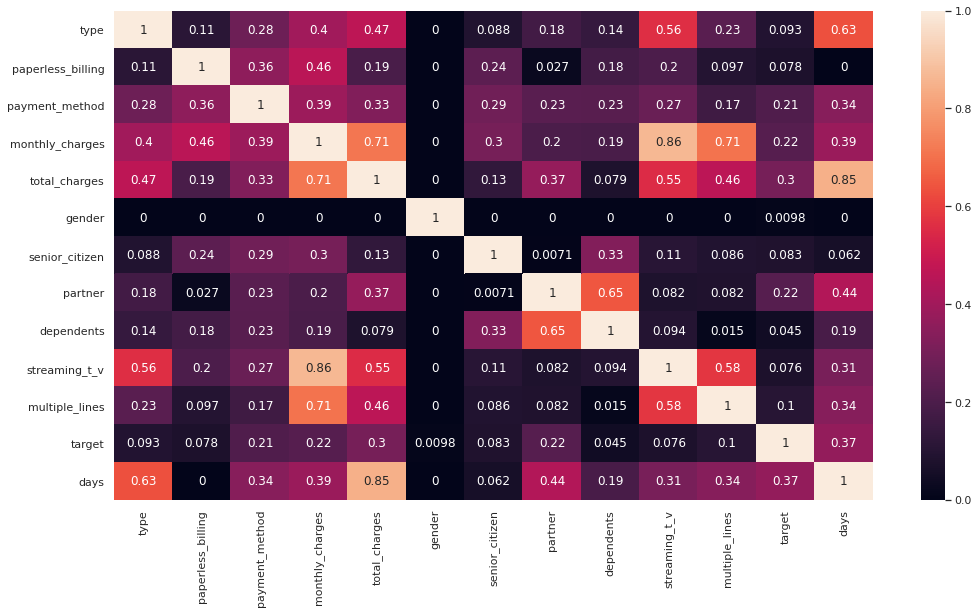

In [29]:
corr=df.phik_matrix()
sns.set(rc = {'figure.figsize':(17,9)})
sns.heatmap(data=corr,annot=True,);

In [30]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,streaming_t_v,multiple_lines,target,days
0,Month-to-month,Yes,Electronic check,29,31,Female,0,Yes,No,No,No_servis,0,31
1,One year,No,Mailed check,56,2071,Male,0,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53,226,Male,0,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42,1960,Male,0,No,No,No,No_servis,0,1371
4,Month-to-month,Yes,Electronic check,70,353,Female,0,No,No,No,No,0,153


Что бы определить значимость признаков их нужно привести к числовым значениям.

In [31]:
df1 = df.copy()

In [32]:
df1.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,streaming_t_v,multiple_lines,target,days
0,Month-to-month,Yes,Electronic check,29,31,Female,0,Yes,No,No,No_servis,0,31
1,One year,No,Mailed check,56,2071,Male,0,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53,226,Male,0,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42,1960,Male,0,No,No,No,No_servis,0,1371
4,Month-to-month,Yes,Electronic check,70,353,Female,0,No,No,No,No,0,153


Прверим важность двумя способами и сравним их.

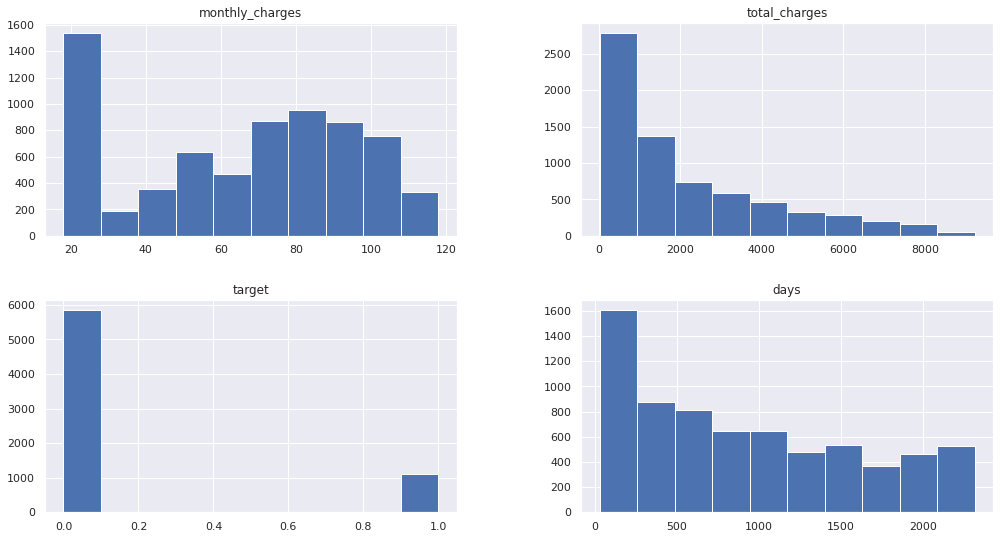

In [33]:
df.hist();

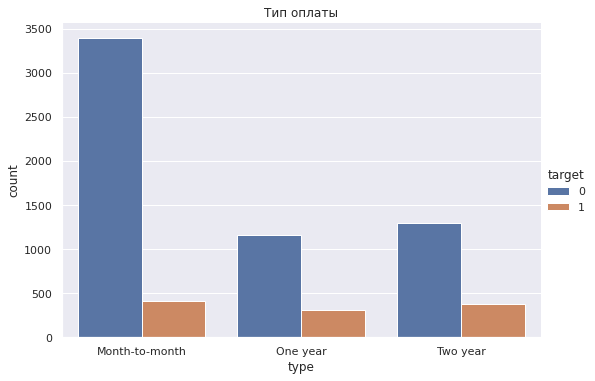

In [34]:
sns.catplot(data = df,hue = 'target', x = 'type',
            kind='count', height=5, aspect=1.5).set(title='Тип оплаты');

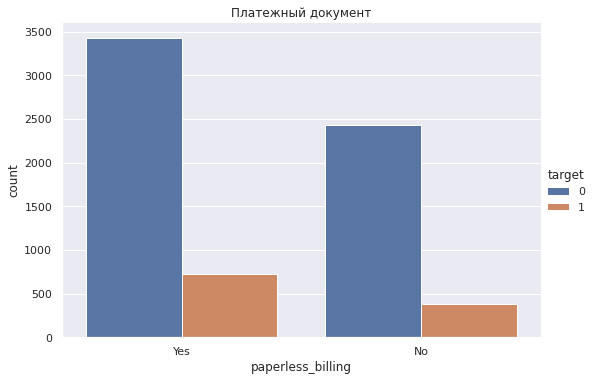

In [35]:
sns.catplot(data = df,hue = 'target', x = 'paperless_billing',
            kind='count', height=5, aspect=1.5).set(title='Платежный документ');

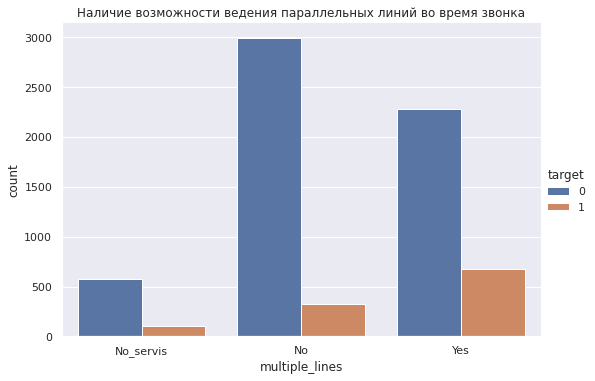

In [36]:
sns.catplot(data = df,hue = 'target', x = 'multiple_lines',
            kind='count', height=5, aspect=1.5).set(title='Наличие возможности ведения параллельных линий во время звонка');

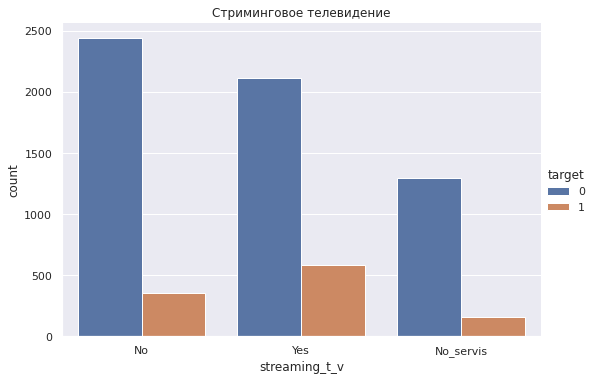

In [37]:
sns.catplot(data = df,hue = 'target', x = 'streaming_t_v',
            kind='count', height=5, aspect=1.5).set(title='Стриминговое телевидение');


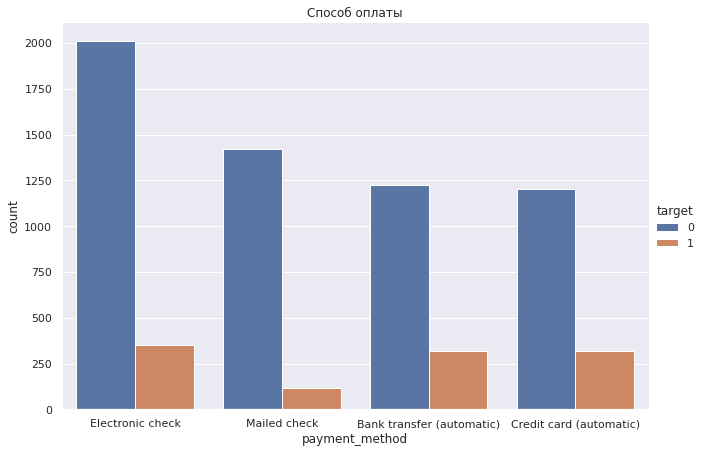

In [38]:
sns.catplot(data = df,hue = 'target', x = 'payment_method',
            kind='count', height=6, aspect=1.5).set(title='Способ оплаты');

**Вывод**   
Мы получили в распоряжение 4 таблицы, в которых есть общий столбец customer_id по нему мы и объединили их в одну таблицу.   
Далее добавили столбец с целевым признаком и столбец с количеством дней, которые клиент находится на обслуживании в этой компании.  
Проверили корреляцию признаков, выделили сильно коррелирующие(выше 0.9) и определили наименее выжные признаки, лишние столбцы с датой и те, которые не влияют на результат - удалили.   
Далее заполнили пропуски значениями 'no_service', тк предположили, что если есть пропуск, значит клиент не пользуется даннной услугой.   
Далее визуализировали все признаки для наглядности.

# Обучение и выбор модели

Разделим данные на выборки 75 и 25%%.

In [40]:

target = df['target']
features = df.drop('target', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)


print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)


(5219, 12) (1740, 12) (5219,) (1740,)


In [41]:
df.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents',
       'streaming_t_v', 'multiple_lines', 'target', 'days'],
      dtype='object')

In [42]:
pd.options.mode.chained_assignment = None  # default='warn'
# Создаем список столбцов, подлежащих кодированию
ohe_columns = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents',
       'streaming_t_v', 'multiple_lines']

# Создаем объект one-hot encoder
ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

# Применяем метод fit 
ohe.fit(features_train[ohe_columns])

# Добавляем закодированные признаки 
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок

features_train[ohe.get_feature_names()] = ohe.transform(features_train[ohe_columns])
features_test[ohe.get_feature_names()] = ohe.transform(features_test[ohe_columns])

# Удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_columns, axis=1)
features_test = features_test.drop(ohe_columns, axis=1)

features_train.head()

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,monthly_charges,total_charges,days,x0_One year,x0_Two year,x1_Yes,x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_Male,x4_1,x5_Yes,x6_Yes,x7_No_servis,x7_Yes,x8_No_servis,x8_Yes
6766,79,238,92,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4711,78,255,92,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6045,59,1181,580,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1910,72,4679,1798,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
5392,84,169,62,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [43]:
features_train.shape

(5219, 17)

Начнем проверку моделей.   
Начнем с Модели Случайный лес

In [44]:
model_rf= RandomForestClassifier(random_state=RANDOM_STATE)
param_grid = {
    'max_depth' : range(18,19),
    'n_estimators' : range(74,76),
    'min_samples_split': (3, 5),
    'min_samples_leaf': (5, 6)
}
grid = GridSearchCV(model_rf, param_grid = param_grid, scoring = 'roc_auc', cv=TimeSeriesSplit(n_splits=5))
model_rf = grid.fit(features_train,target_train)

print('Наилучшее значение roc_auc ', (model_rf.best_score_), 'при параметрах', model_rf.best_params_)

Наилучшее значение roc_auc  0.8088335286722195 при параметрах {'max_depth': 18, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 74}


Логистическая регрессия

In [45]:
model_lr = LogisticRegression(random_state=RANDOM_STATE ,class_weight='balanced', max_iter=3000)
parameters = {'solver': ['lbfgs', 'liblinear'],
             'C': [1, 3, 10]}

grid_clf = GridSearchCV(model_lr, parameters, cv=5, scoring='roc_auc')
model_lr = grid_clf.fit(features_train, target_train)
print('Наилучшее значение roc_auc ', model_lr.best_score_, 'при параметрах', model_lr.best_params_)

Наилучшее значение roc_auc  0.7560952196841999 при параметрах {'C': 10, 'solver': 'liblinear'}


In [46]:
param_grid = {'iterations': [1000], 
               'learning_rate': [0.1],
               'depth': [6],
              }
              
                 

model_cb = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

grid_cb = GridSearchCV(model_cb, param_grid, cv=7, scoring='roc_auc')
grid_cb.fit(features_train, target_train)

print('Наилучшее значение roc_auc ', grid_cb.best_score_, 'при параметрах', grid_cb.best_params_)


Наилучшее значение roc_auc  0.9174628942046853 при параметрах {'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}


In [47]:
tab = [[round(model_rf.best_score_,2)],
      [round(model_lr.best_score_,2)],
     [round(grid_cb.best_score_,2)]]
model = ['RandomForestClassifier', 'LogisticRegression', 'CatBoostClassifier']
pd.DataFrame(data=tab, index=model, columns=['AUC'])

,AUC
RandomForestClassifier,0.81
LogisticRegression,0.76
CatBoostClassifier,0.92


Наилучший результат показала модель CatBoostClassifier, проверим ее на тестовой выборке.  

In [48]:
predictions = grid_cb.predict(features_test)
score_auc = roc_auc_score(target_test, grid_cb.predict_proba(features_test)[:, 1])
score_acc = accuracy_score(target_test, predictions)
print("Значение roc_auc:", score_auc)
print("Значение accuracy:", score_acc)

Значение roc_auc: 0.9199739373254733
Значение accuracy: 0.9155172413793103


In [49]:
#КОД РЕВЬЮЕРА
predictions = grid_cb.best_estimator_.predict(features_test)
score_auc = roc_auc_score(target_test, grid_cb.best_estimator_.predict_proba(features_test)[:, 1])
score_acc = accuracy_score(target_test, predictions)
print("Значение roc_auc:", score_auc)
print("Значение accuracy:", score_acc)

Значение roc_auc: 0.9199739373254733
Значение accuracy: 0.9155172413793103


Необходимый результат достигнут!!!   
Теперь проверим, какие признаки были наиболее важными при обучении! 

In [50]:
fi = pd.DataFrame()
fi['importance'] = grid_cb.best_estimator_.feature_importances_
fi['feature_name'] = grid_cb.best_estimator_.feature_names_
fi = fi.sort_values (by = ['importance'], ascending = False, ignore_index = True)
fi

,importance,feature_name
0,44.292311,days
1,11.876731,total_charges
2,11.670997,monthly_charges
3,4.689149,x0_Two year
4,4.110309,x5_Yes
5,3.085687,x6_Yes
6,2.935158,x0_One year
7,2.640676,x8_Yes
8,2.402693,x2_Electronic check
9,2.260755,x3_Male


Для наглядности и удобства построим график

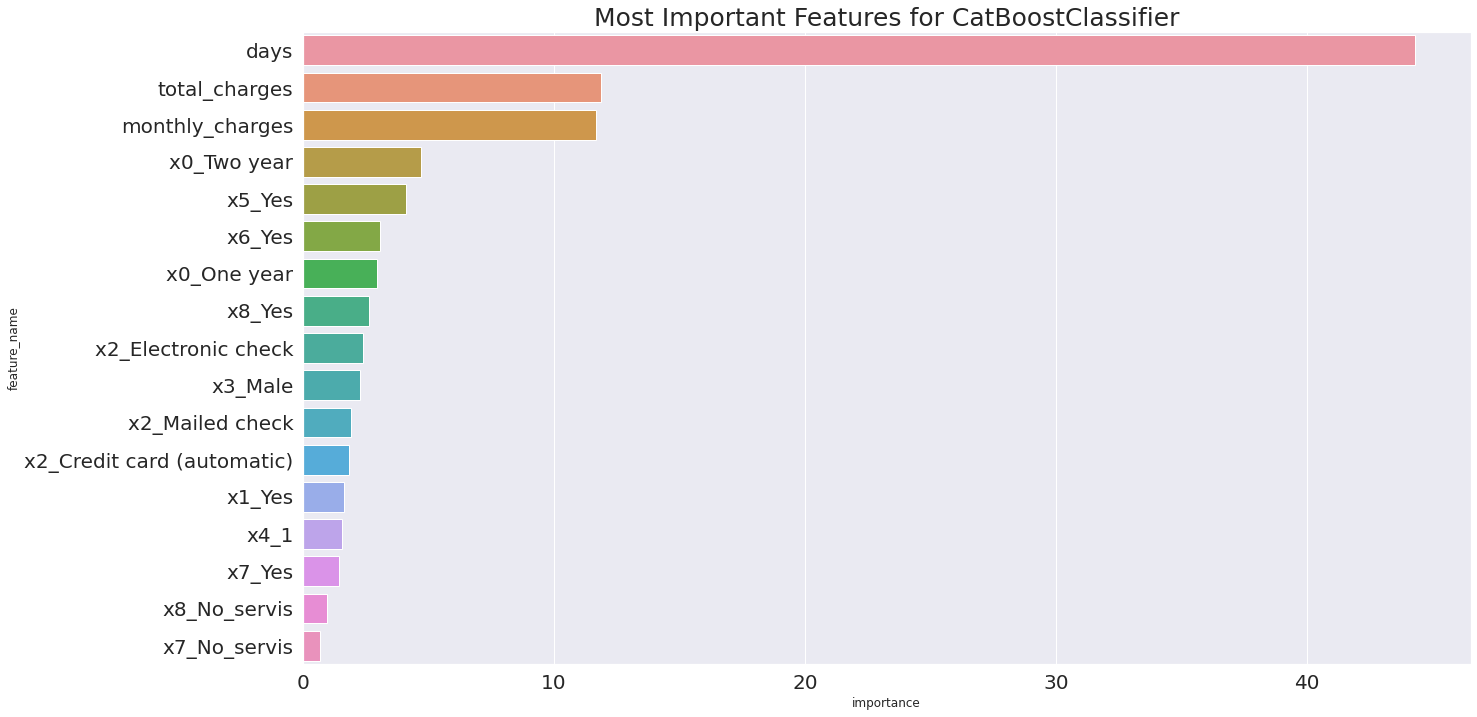

In [51]:
plt.figure(figsize=(19, 10))
sns.barplot(x="importance", y="feature_name", data=fi)

plt.title('Most Important Features for CatBoostClassifier', size=25)
plt.tight_layout()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show();

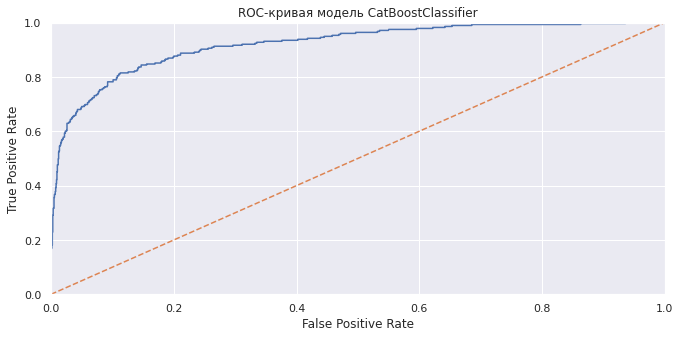

In [52]:

    
fpr, tpr, thresholds = roc_curve(target_test, grid_cb.predict_proba(features_test)[:, 1])

plt.figure(figsize=(11, 5))
    
plt.plot(fpr, tpr)
    
plt.plot([0, 1], [0, 1], linestyle='--')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
plt.title('ROC-кривая модель CatBoostClassifier')
    
plt.show()

In [53]:
cm = confusion_matrix(target_test, predictions)
cm

array([[1442,   23],
       [ 124,  151]])

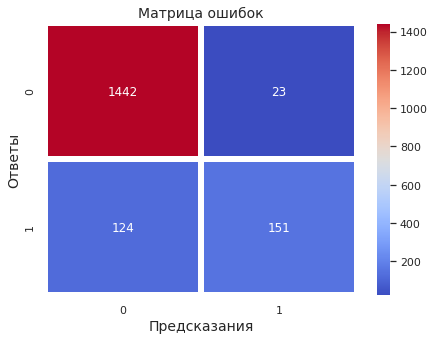

In [54]:
plt.figure(figsize = (7,5))
ax = plt.axes()

sns.heatmap(cm, annot=True, fmt='d', cmap= 'coolwarm', linewidths=5, ax=ax)
    
ax.set_title('Матрица ошибок', fontdict={'fontsize':14})
ax.set_xlabel('Предсказания', fontsize=14)
ax.set_ylabel('Ответы', fontsize=14)

plt.show()

Значения в  матрице ошибок   

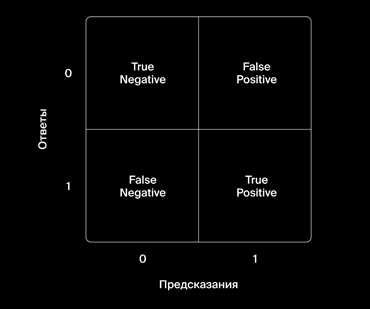

**Вывод**   
Наилучшее качество предсказания показала модель CatBoostClassifier, на трэйне roc_auc = 0,92, на тестовой выборке roc_auc = 0.92 , accuracy = 0.91.   
Наиболее важными признаками являются:   
days - количество дней на обслуживании,   
total_charges - общая сумма, которую клиент заплатил за всё время услуг,   
monthly_charges - ежемесячный платёж за услуги,   
type_Two year - тип оплаты.   


# Отчет по решению.

Нашей задачей было создать модель, которая предскажет отток клиентов из компании  «Ниединогоразрыва.ком». Точность предсказания модели по метрике AUC-ROC должна быть выше 0.85.   

Нам были даны  4 таблицы с информацией о клиентах, датах заключения договора, дате разрыва договора, сумм затрат на ежемесячные платежи и общих сумм затрат клиента, персональной информации о клиентах, сведения об услугах интрернета, телефонии и доп. услугах. Мы загрузили и ознакомились с данными. 

Для удобства обработки таблицы объединили в одну общую по полю Customer_id.   

Получили общую таблицу размером 20 колонок и 7043 строки.   

Все названия колонок привели к общему стилю и нижнему регистру.

Обнаружили 11 пропусков в признаке "total_charges", тк это совсем маленькое количество было принято решение удалить их.
У некоторых признаков изменили тип на int.

Далее добавили целевой признак по принципу, если у клиента есть дата расторжения договора, значит он ушел и ему присваиваем значение 1, если он еще на обслуживании присваиваем значение 0.   

Далее создали еще один признак это количество дней на обслуживании. после его добавления признаки с датой начала и конца обслуживания удалили.  
Во всех остальных столбцах пропучки заполнили значением "No servis", тк предположили, что ели нет данных, значит клиент не пользуется даннной услугой.   
Проверили и удалили дубликаты.   
Далее оценили корреляцию категорийных и численных признаков. Признаки где корреляция была выше 0.9 удалили, что бы не перегружать модель.   
После визуализировали все признаки. Увидели, что число дней на обслуживании в основном до 700, ежемесячные траты у большинства клиентов до 30 долларов, оставшихся клиентов было в 6 раз больше, чем ушедших.   
По категорийным признакам увидели, что основная часть оставшихся клиентов вносит олату ежемесячно, многие, кто ушел использовал электронный платежный документ и возможность ведения параллельных линий во время звонка, так же использовали стриминговое телевидение.    
То есть у них было подключено достаточно много доп. услуг.

Далее перешли к обучению, разделили наш датасет на 2 части 75 и 25%, выделили целевой признак "target".   
Закодировали данные методом OHE.    
Обучение начали с модели случайного леса, она дала нам результат 0,81, этого мало.   
Логистическая регрессия дала еще хуже результат 0,76.  
После мы перешли к модели CatBoostClassifier и вот она уже дала нам уверенные 0,92!   
Для этого были использованы параметры модели:   
-RANDOM_STATE = 140823  
-verbose = 0       
-iterations = 1000   
-learning_rate = 0.1   
-depth = 6   
-cv = 7.   
   

При проверке на тестовой выборке результат сохранился и получился AUC = 0,92 и ACCURACY тоже 0,92. 

Далее мы проверили, какие признаки были наиболее важными при обучении, ими оказались:
-days   
-total_charges   
-monthly_charges    
Конечно же, для наглядности мы их визуализировали!    
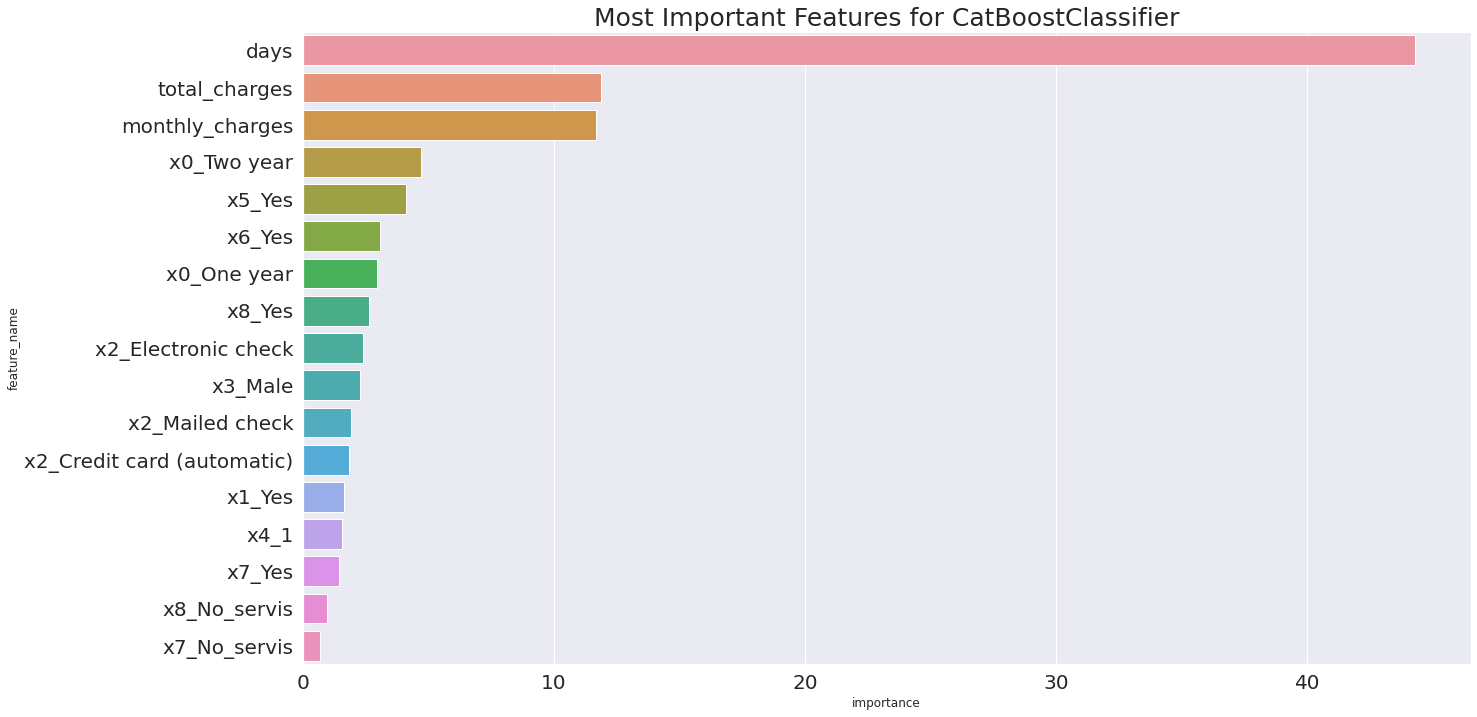   
После построили ROC-кривую   
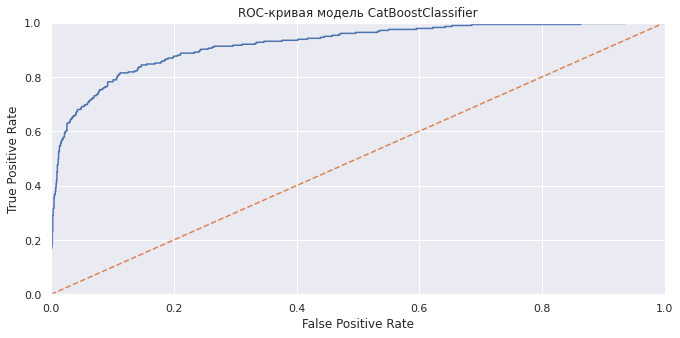   

и матрицу ошибок, по ней мы заметили, что модель дает больше ложноотрицательных.      

- Какие пункты плана были выполнены, а какие — нет. Почему?   
Все пункты плана были выполнены.     

- Какие трудности возникли и как вы их преодолели?   
Особых трудностей не возникло, теории из курса хватило для выполнения проекта, все нюансы объяснил тимлид.     

- Какие ключевые шаги в решении задачи вы выделили?   
Ключевые шаги это загрузка, ознакомление, анализ данных, построение моделей и тестирование наилучшей.    

- Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?   
Для обучения были использованы все признаки не имеющие корреляции. А так же добавлен новый признак "Дни на обслуживании".   

- Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?   
Лучшая модель CatBoostClassifier, она уже дала нам ROC_AUC 0,92.  
Для этого были использованы параметры модели:   
-RANDOM_STATE = 140823  
-verbose = 0       
-iterations = 1000   
-learning_rate = 0.1   
-depth = 6   
-cv = 7.   